In [570]:
import cv2
def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov

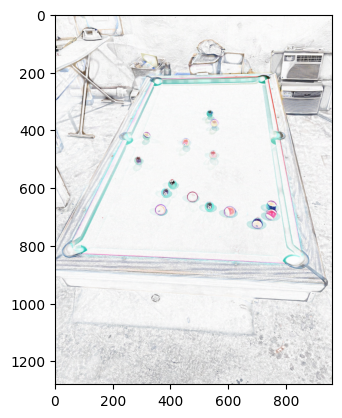

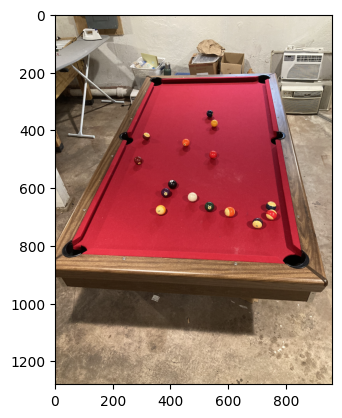

In [571]:
from sympy import Point, Ellipse
import matplotlib.pyplot as plt
import numpy as np
x1='images/most_balls/1280x1280/IMG_3207.png'
grayscale = cv2.imread(x1, 0)
color = cv2.imread(x1,1)
no_shadow = shadow_remove(color)
plt.imshow(cv2.cvtColor(no_shadow, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
plt.show()

## Threshold by color and mask

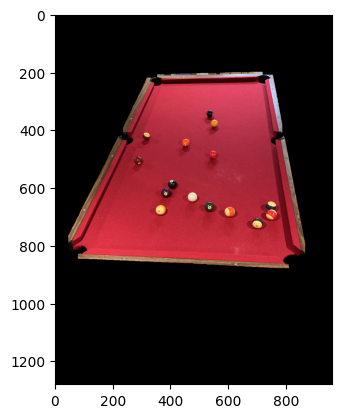

In [572]:
# order is blue, green, red
lower_blue = np.array([0,0,150])
upper_blue = np.array([150,100,255])
mask = cv2.inRange(color, lower_blue, upper_blue)
kernel = np.ones((7,7),np.uint8)
dilation = cv2.dilate(mask, kernel, iterations = 5)
# dilation is grayscale, lets convert it to have three channels
rgb_dilation = np.uint8(np.zeros((dilation.shape[0], dilation.shape[1], 3)))
for i in range(rgb_dilation.shape[0]):
    for j in range(rgb_dilation.shape[1]):
        rgb_dilation[i][j][:] = dilation[i][j]

res = cv2.bitwise_and(color, rgb_dilation)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)
plt.show()

In [573]:
# scale = 1
# delta = 0
# ddepth = cv2.CV_16S
# res = cv2.GaussianBlur(rgbres, (9,9), 0)
# borderType = cv2.BORDER_ISOLATED
# grad_x = cv2.Sobel(res, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=borderType)
# grad_y = cv2.Sobel(res, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=borderType)
# grad_y = cv2.Scharr(res,ddepth,0,1)
# grad_x = cv2.Scharr(res,ddepth,1,0)
#
# abs_grad_x = cv2.convertScaleAbs(grad_x)
# abs_grad_y = cv2.convertScaleAbs(grad_y)
#
# grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
# blurred = cv2.bilateralFilter(grad, 9, 75, 75)
# plt.imshow(grad)
# plt.show()

## Hough Circles

True

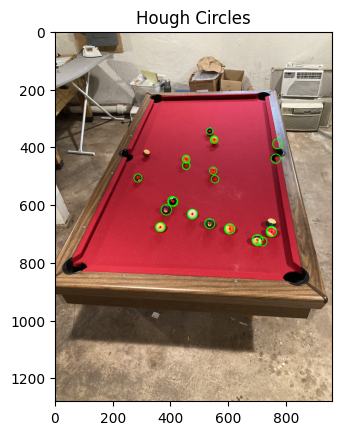

In [578]:
cimg = color
graygrad = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)

# graygrad = cv2.GaussianBlur(graygrad, (7, 7), 0)
# cimg = cv2.cvtColor(grad,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(graygrad,cv2.HOUGH_GRADIENT_ALT,param1=300, param2=0.7, dp=2, minRadius=10, maxRadius=20, minDist=10)
circles = np.uint16(np.around(circles))

for i in circles[0,:]:
# for i in range(5):
    # cv2.circle(cimg, (100*i,110*i), 16, (0,255,0), 2)
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.title("Hough Circles")
plt.imshow(cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
cv2.imwrite('images/circles.png', cimg)

